In [2]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 24.7 MB/s eta 0:00:00


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import mne
import os

# Sample EEG data loading (replace with your data loading mechanism)
# Assuming X is your EEG data with shape (num_samples, time_steps, num_channels)
# Assuming y is your label data with shape (num_samples, num_classes) for classification

Extracting EDF parameters from /content/S001R03.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
<Info | 8 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: 3 items (dict)
>
Using matplotlib as 2D backend.


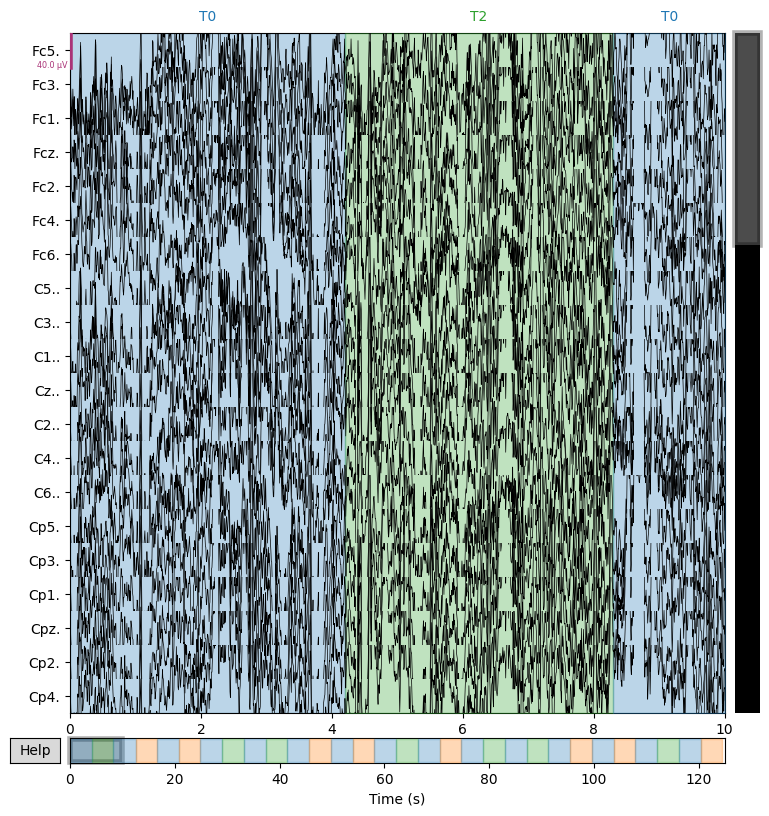

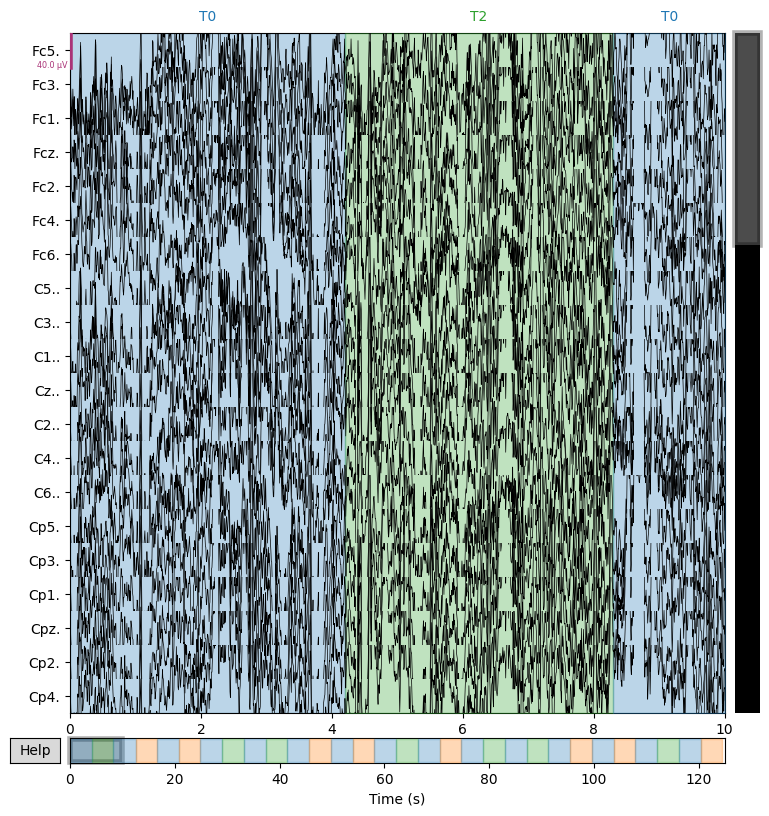

In [5]:
# Load a sample subject's data
raw = mne.io.read_raw_edf('/content/S001R03.edf', preload=True)

# Display basic information
print(raw.info)
raw.plot()  # Optional: Visualize the EEG data

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 s)

<Info | 8 non-empty values
 bads: []
 ch_names: Fc5., Fc3., Fc1., Fcz., Fc2., Fc4., Fc6., C5.., C3.., C1.., ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 1.0 Hz
 lowpass: 40.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: 3 items (dict)
>


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


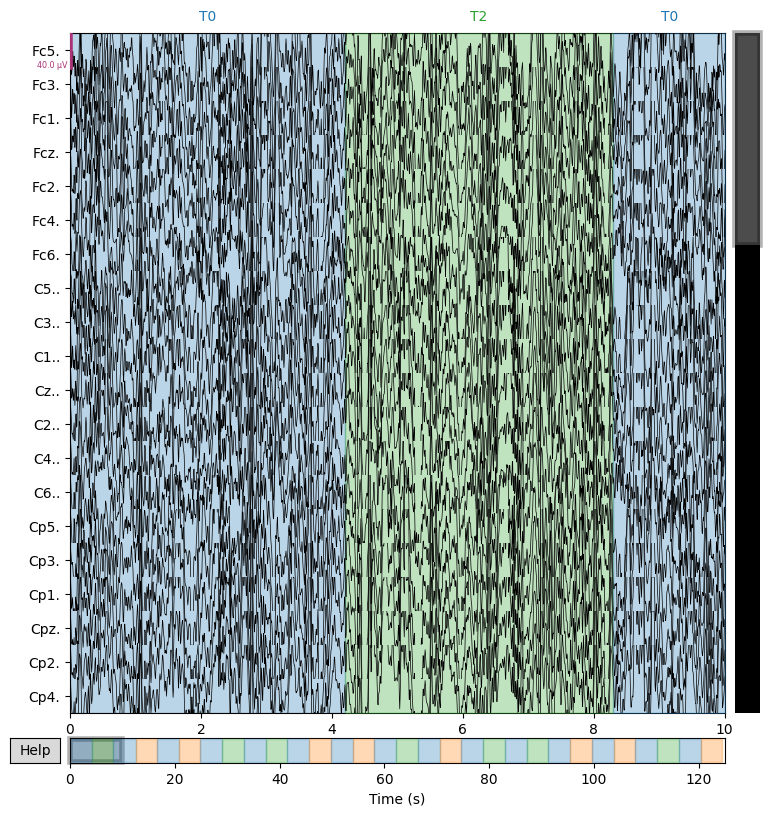

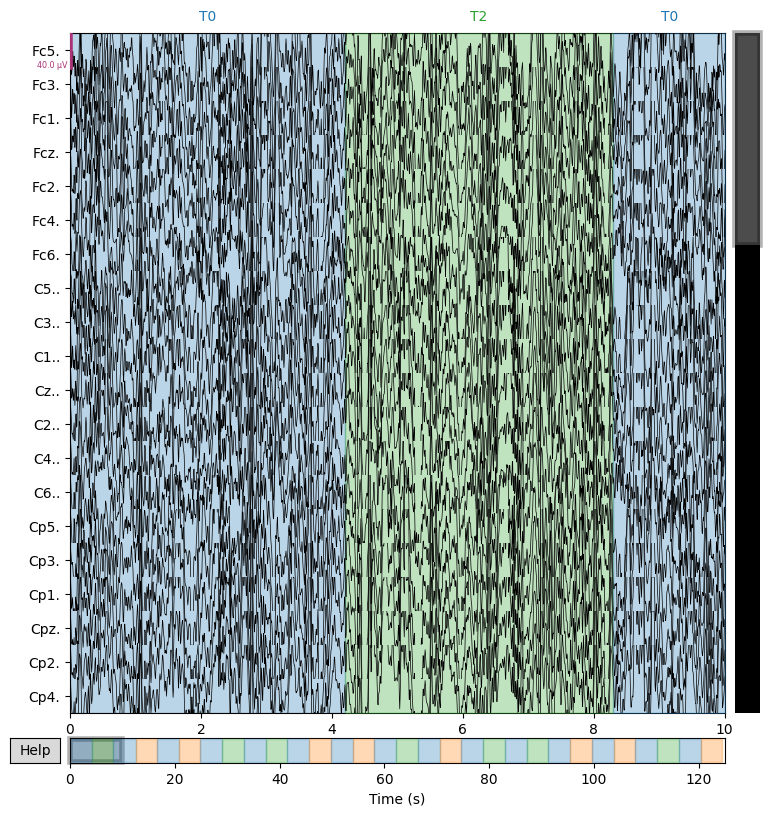

In [6]:
# Apply bandpass filter to retain frequencies between 13 Hz and 30 Hz
raw_filtered = raw.filter(1., 40., fir_design='firwin')
print(raw_filtered.info)
raw_filtered.plot()  # Optional: Visualize the EEG data

In [7]:
print(type(raw))
print(raw.annotations)

<class 'mne.io.edf.edf.RawEDF'>
<Annotations | 30 segments: T0 (15), T1 (8), T2 (7)>


In [8]:
events, event_id = mne.events_from_annotations(raw)

event_id = {
    'rest': 1,  # rest
    'left/fist': 2,  # left hand movement
    'right/feet': 3,  # right hand movement
    # Add more as needed
}

# Define the epoching parameters
tmin = -0.2  # Start of each epoch (200 ms before the event)
tmax = 0.5   # End of each epoch (500 ms after the event)
baseline = (None, 0)  # Baseline correction

print(events)
print(event_id)


Used Annotations descriptions: ['T0', 'T1', 'T2']
[[    0     0     1]
 [  672     0     3]
 [ 1328     0     1]
 [ 2000     0     2]
 [ 2656     0     1]
 [ 3328     0     2]
 [ 3984     0     1]
 [ 4656     0     3]
 [ 5312     0     1]
 [ 5984     0     3]
 [ 6640     0     1]
 [ 7312     0     2]
 [ 7968     0     1]
 [ 8640     0     2]
 [ 9296     0     1]
 [ 9968     0     3]
 [10624     0     1]
 [11296     0     2]
 [11952     0     1]
 [12624     0     3]
 [13280     0     1]
 [13952     0     3]
 [14608     0     1]
 [15280     0     2]
 [15936     0     1]
 [16608     0     2]
 [17264     0     1]
 [17936     0     3]
 [18592     0     1]
 [19264     0     2]]
{'rest': 1, 'left/fist': 2, 'right/feet': 3}


Not setting metadata
30 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 30 events and 161 original time points ...
1 bad epochs dropped


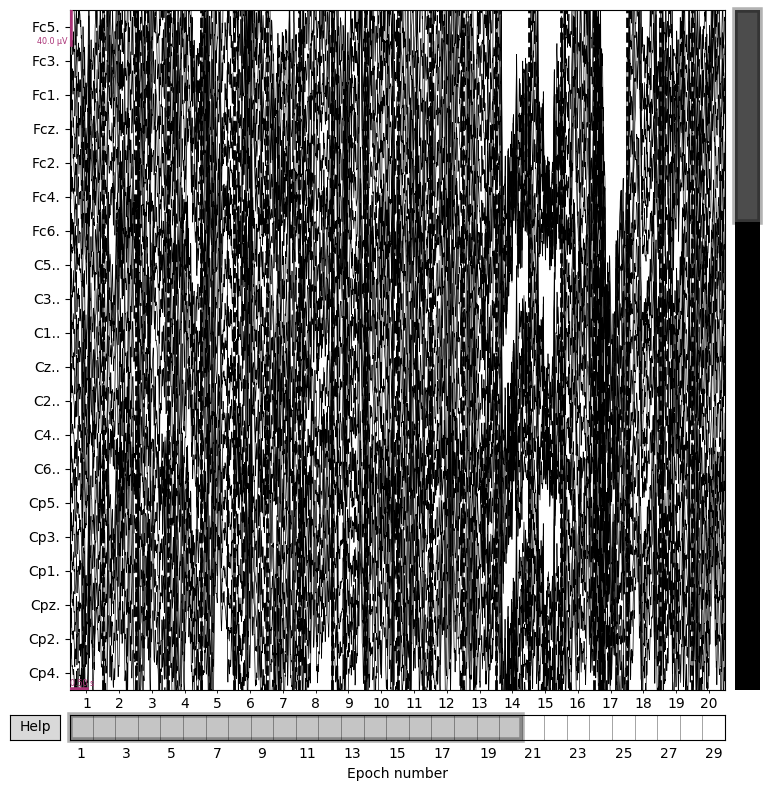

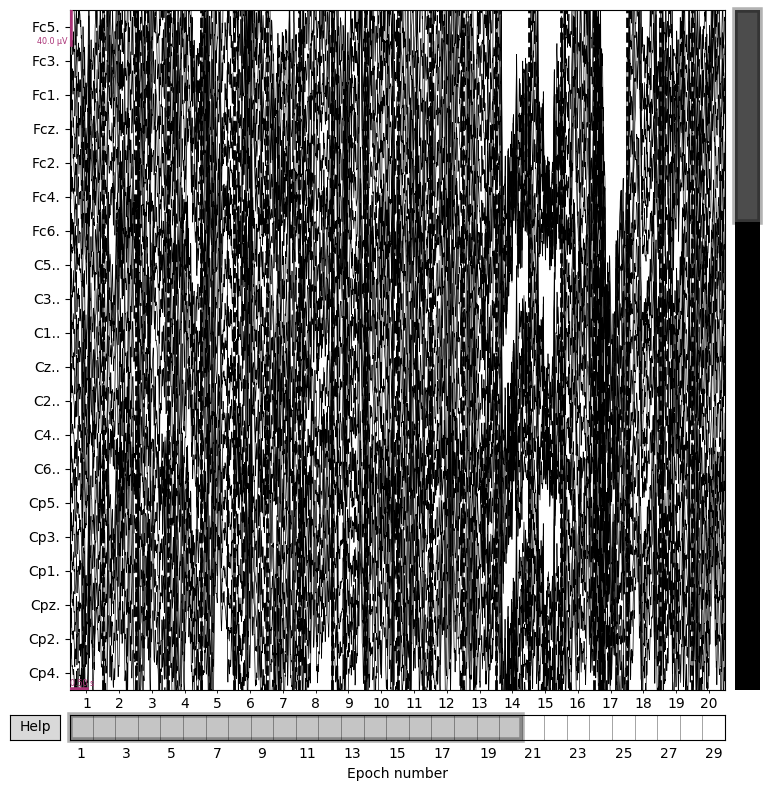

In [9]:
epochs = mne.Epochs(raw_filtered, events, event_id, tmin=-0.2, tmax=0.8, baseline=(None, 0), preload=True)
epochs.plot()

In [10]:
sampling_rate = raw.info['sfreq']
print(f'Sampling rate: {sampling_rate} Hz')
#data's sampling rate is not very high (<512Hz), don't need to downsample

Sampling rate: 160.0 Hz


In [11]:
#6. LABEL ENCODING
X = epochs.get_data()  # Shape will be (n_epochs, n_channels, n_times)
y = epochs.events[:, -1]  # Labels corresponding to events
print(X) #the signals -- why/how is it expressed in decimals?
print(y)


[[[-2.06364058e-05 -3.80503859e-06  9.54571365e-06 ... -1.10091050e-05
   -1.81197142e-05 -2.68781223e-05]
  [-8.56624106e-06  4.78793289e-06  8.48033925e-06 ... -1.97649520e-05
   -1.79070868e-05 -2.20035812e-05]
  [-5.76859397e-06  1.53709268e-05  1.65906292e-05 ... -1.18348267e-05
   -9.07852852e-06 -1.13369717e-05]
  ...
  [ 1.76907643e-05  1.74429914e-05  1.82988258e-05 ...  2.37804463e-06
    3.92471509e-06  3.17867905e-06]
  [ 7.36308771e-06  2.93726487e-06 -5.03266582e-06 ...  8.05431654e-06
    1.81269811e-05  1.94503280e-05]
  [-1.13819689e-06 -3.86914293e-06 -6.21108548e-06 ...  8.95999509e-06
    1.28692002e-05  5.16907704e-06]]

 [[ 7.75068879e-06  2.72989325e-05  3.35718690e-05 ...  7.08836302e-05
    4.69342121e-05  3.40219946e-05]
  [ 2.01110908e-05  3.28039061e-05  3.22278703e-05 ...  4.94400796e-05
    2.99841684e-05  1.44802606e-05]
  [ 1.58824418e-05  2.83778433e-05  2.79190639e-05 ...  2.74122869e-05
    9.39666717e-06 -2.21299603e-06]
  ...
  [-1.37773731e-05 -4.4

<ipython-input-11-171043049fa7>:2: FutureWarning: The current default of copy=False will change to copy=True in 1.7. Set the value of copy explicitly to avoid this warning
  X = epochs.get_data()  # Shape will be (n_epochs, n_channels, n_times)


In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
n_epochs, n_channels, n_times = X.shape
X_reshaped = X.reshape(n_epochs * n_channels, n_times) #Reshapes the 3D data array X into a 2D array for normalization.
X_normalized = scaler.fit_transform(X_reshaped)
X_normalized = X_normalized.reshape(n_epochs, n_channels, n_times) #Reshapes the normalized data back to its original 3D shape
print(X_reshaped)
print(X_normalized)

[[-2.06364058e-05 -3.80503859e-06  9.54571365e-06 ... -1.10091050e-05
  -1.81197142e-05 -2.68781223e-05]
 [-8.56624106e-06  4.78793289e-06  8.48033925e-06 ... -1.97649520e-05
  -1.79070868e-05 -2.20035812e-05]
 [-5.76859397e-06  1.53709268e-05  1.65906292e-05 ... -1.18348267e-05
  -9.07852852e-06 -1.13369717e-05]
 ...
 [-1.74759615e-05 -1.05395704e-05 -2.57804803e-07 ... -4.80322746e-05
  -5.50415108e-05 -6.13210523e-05]
 [-3.33377839e-05 -1.84726660e-05  1.05009705e-06 ... -8.33194981e-05
  -8.27636539e-05 -7.23093632e-05]
 [-2.06706680e-05 -1.25919033e-05  2.76341931e-06 ... -5.24003213e-05
  -5.05069670e-05 -7.21402092e-05]]
[[[-0.32184656  0.10667995  0.50204434 ... -0.200852   -0.29635529
   -0.43413911]
  [-0.00595376  0.33292853  0.47243415 ... -0.3181616  -0.29332292
   -0.36225498]
  [ 0.06726451  0.6115734   0.69784522 ... -0.2119149  -0.16741533
   -0.2049561 ]
  ...
  [ 0.68122815  0.66612981  0.7453215  ... -0.02149286  0.01802911
    0.00910402]
  [ 0.41093866  0.28420138

In [55]:
for i in range(len(y)):
  y[i] = y[i] - 1

In [57]:
from tensorflow.keras.utils import to_categorical

y = to_categorical(y, num_classes=len(event_id))

In [58]:
#8. Splitting the Dataset (into training set and testing set)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

In [59]:
model = Sequential()
model.add(SimpleRNN(units=64, return_sequences=True, input_shape=(n_times, 161)))
model.add(Dropout(0.2))
model.add(SimpleRNN(units=64))  # Another RNN layer to process the sequence
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [60]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [61]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32,
                    validation_data=(X_test, y_test), verbose=1)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step - accuracy: 0.2609 - loss: 1.4587 - val_accuracy: 0.6667 - val_loss: 0.9186
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.5217 - loss: 1.1025 - val_accuracy: 0.6667 - val_loss: 0.9744
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.3478 - loss: 1.1689 - val_accuracy: 0.5000 - val_loss: 1.0224
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.5652 - loss: 0.8584 - val_accuracy: 0.5000 - val_loss: 1.0593
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step - accuracy: 0.6957 - loss: 0.6365 - val_accuracy: 0.5000 - val_loss: 1.1002
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step - accuracy: 0.8696 - loss: 0.5791 - val_accuracy: 0.5000 - val_loss: 1.1387
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step - accuracy: 0.7826 - loss: 0.5861 - val_accuracy: 0.5000 - val_loss: 1.1767
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.7391 - loss: 0.5619 - val_accuracy: 0.5000 - va

In [62]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy:.2f}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3333 - loss: 2.1374
Test accuracy: 0.33
